## Theoretical curves

In [1]:
import numpy as np
from matplotlib import pyplot as plt

In [2]:
# Exact dynamics, approximate solution

def dudt(u, c, r, s, l):
    return np.sqrt(c**2 + r**2 * u**2) * (s - l * u)

def solve_dynamics(c, r, s, l, u0, tau): 
    
    u_traj = np.zeros((tau,))
    
    # Initialisation
    u_traj[0] = u0    
    for i in range(tau - 1):
        u_traj[i + 1] = u_traj[i] + dudt(u_traj[i], c, r, s, l)
    
    return u_traj


def loop_dynamics_l(c, r, s, l_list, u0, tau):
    
    u_traj = []
    for l in l_list:
        u_traj.append(solve_dynamics(c, r, s, l, u0, tau))
        
    return np.row_stack(u_traj)


def loop_dynamics_s(c, r, s_list, l, u0, tau):
    
    u_traj = []
    for s in s_list:
        u_traj.append(solve_dynamics(c, r, s, l, u0, tau))
        
    return np.row_stack(u_traj)


In [3]:
# Exact dynamics (note: works only for a limited set of hyperparameters)
# TODO: something seems off as train loss does not go to 0

def sech(x):
    return  1 / np.cosh(x)

def u_one_layer(r, s, l, u0, t):
    return np.exp(-l * r * t) * (u0 - s / l) + s / l

def u_two_layer_simplified(r, s, l, u0, t):
    
    exp_term = np.exp(2 * s * r * t)
    
    return s * exp_term / (l * (exp_term - 1) + s / u0)

def u_exact(c, r, s, l, u0, t, tol=1e-7):
    
    if abs(c) < tol:
        return u_two_layer_simplified(r / 2, s, l, u0, t) # We use r = 2 \sqrt{ra * rb}
        
    elif r < tol:
        return u_one_layer(c, s, l, u0, t) # The learning rate in this case is c
        
    else:
        
        k = np.sqrt(c**2 * l**2 + r**2 * s**2)
        
        g_u0 = np.arctanh((r * (s - l * u0) + l * np.sqrt(c**2 + r**2 * u0**2)) / k)
        t_term = k * t + 2 * g_u0
        
        n = sech(0.5 * t_term)**2 * (c**2 * l**2 + r * s * (-r * s * np.cosh(t_term) + k * np.sinh(t_term)))
        d = 2 * l * r * (r * s - k * np.tanh(0.5 * t_term))
        
        return n / d

In [26]:
# Approximate dynamics

def u(c, r, s, l, u0, t):
    
    n = s * (r * u0 + c) * np.exp((c * l + r * s) * t) + c * (l * u0 - s)
    d = l * (r * u0 + c) * np.exp((c * l + r * s) * t) - r * (l * u0 - s)
    
    return n / d


def z_true(s, l, e):
    return s / l - e / np.sqrt(l)


def mse_global(s, l, u):
    return (s / l - u)**2


def mse_true(s, l, e, u):
    return (z_true(s, l, e) - u)**2


def mse_train(c, r, s1, s2, l1, l2, d, p, u0, t):
    
    return ((d - p) / d) * l1 * mse_global(s1, l1, u(c, r, s1, l1, u0, t)), (p / d) * l2 * mse_global(s2, l2, u(c, r, s2, l2, u0, t))


def mse_test(c, r, s1, s2, l1, l2, e1, e2, d, p, u0, t):
    
    return ((d - p) / d) * l1 * mse_true(s1, l1, e1, u(c, r, s1, l1, u0, t)), (p / d) * l2 * mse_true(s2, l2, e2, u(c, r, s2, l2, u0, t))  

In [19]:
def plot_res(res1, res2, t_range, it_range, titles=["Train", "Test"], vmax=None):
    
    fig, ax = plt.subplots(1, 2, figsize = (10, 5))
    
    new_ticks = np.linspace(0, res1.shape[0], 5).astype(int)[:-1]

    im1 = ax[0].imshow(res1, cmap="viridis", vmax=vmax)
    im2 = ax[1].imshow(res2, cmap="viridis", vmax=vmax)
    
    fig.colorbar(im1, ax=ax[0])
    fig.colorbar(im2, ax=ax[1])
    
    for i in range(2):
        ax[i].set_title(titles[i]) 
        
        ax[i].set_xlabel("t")
        ax[i].set_xticks(new_ticks)
        ax[i].set_xticklabels(t_range[new_ticks].astype(int)) 

        ax[i].set_ylabel(fr"$\lambda$")

        ax[i].set_yticks(new_ticks)
        ax[i].set_yticklabels(it_range[new_ticks].astype(int)) # OBS: AVRUNDNINGEN!!!

    
def plot_curves(res1, res2, t_range, it_range, it="", titles=["Train", "Test"], ylim=1):
    
    fig, ax = plt.subplots(1, 2, figsize = (10, 5))
        
        
    for i in range(0, res1.shape[-1], int(res1.shape[-1] / 10)):
        ax[0].plot(t_range, res1[i, :], label=it + " = " + str(round(it_range[i], 2)))
        ax[1].plot(t_range, res2[i, :], label=it + " = " + str(round(it_range[i], 2)))
    
    for i in range(2):
        ax[i].set_title(titles[i]) 
        ax[i].legend(loc=1)

        
        ax[i].set_xlabel("t")
        ax[i].set_ylabel(fr"$\lambda$")
        
        ax[i].set_ylim([0, ylim])
        #ax[i].set_xscale("log")
        

    plt.show()

## One singular  value

### c < r

In [20]:
# Hps
tau = 200
ts = np.linspace(0, tau, tau)

c, r = 0.001, 0.01
s = 2.5
l1, l2 = 1, 10
d = 10
p1 = 10
u0 = 0.001
e = 0.5

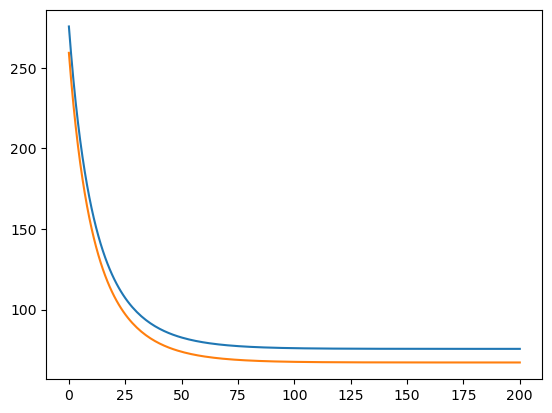

In [21]:
# Exact
u_dyn_1 = u_exact(0.05, 0.01, s, l1, 5.0, ts)
u_dyn_2 = u_exact(0.05, 0.01, s, l1, 5.0, ts)

plt.plot(ts, ((d - p1) / d) * l1 * mse_global(s, l1, u_dyn_1) + (p1 / d) * l2 * mse_global(s, l2, u_dyn_2), label="Train")
plt.plot(ts, ((d - p1) / d) * l1 * mse_true(s, l1, e, u_dyn_1) + (p1 / d) * l2 * mse_true(s, l2, e, u_dyn_2), label = "Test")


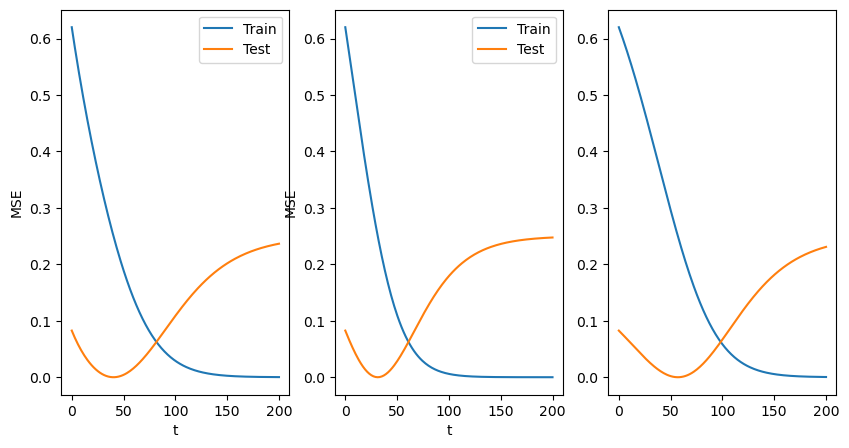

In [30]:
# Test
tau = 200
ts = np.linspace(0, tau, tau)

fig, ax = plt.subplots(1, 3, figsize=(10, 5))

# "Exact"
u_dyn_1 = solve_dynamics(c, r, s, l1, u0, tau)
u_dyn_2 = solve_dynamics(c, r, s, l2, u0, tau)
ax[0].plot(ts, ((d - p1) / d) * l1 * mse_global(s, l1, u_dyn_1) + (p1 / d) * l2 * mse_global(s, l2, u_dyn_2), label="Train")
ax[0].plot(ts, ((d - p1) / d) * l1 * mse_true(s, l1, e, u_dyn_1) + (p1 / d) * l2 * mse_true(s, l2, e, u_dyn_2), label = "Test")


# Approx.
mset_1, mset_2 = mse_train(c, r, s, s, l1, l2, d, p1, u0, ts)
mseg_1, mseg_2 = mse_test(c, r, s, s, l1, l2, e, e, d, p1, u0, ts)
ax[1].plot(ts, mset_1 + mset_2, label = "Train") 
ax[1].plot(ts, mseg_1 + mseg_2, label = "Test")

# Approx. new # Det ser bättre ut??
mset_1, mset_2 = mse_train(0.4 * c, 0.96 * r, s, s, l1, l2, d, p1, u0, ts)
mseg_1, mseg_2 = mse_test(0.4 * c, 0.96 * r, s, s, l1, l2, e, e, d, p1, u0, ts)
ax[2].plot(ts, mset_1 + mset_2, label = "Train") 
ax[2].plot(ts, mseg_1 + mseg_2, label = "Test")

for i in range(2):
    ax[i].set_xlabel("t")
    ax[i].set_ylabel("MSE")
    ax[i].legend()

plt.show()

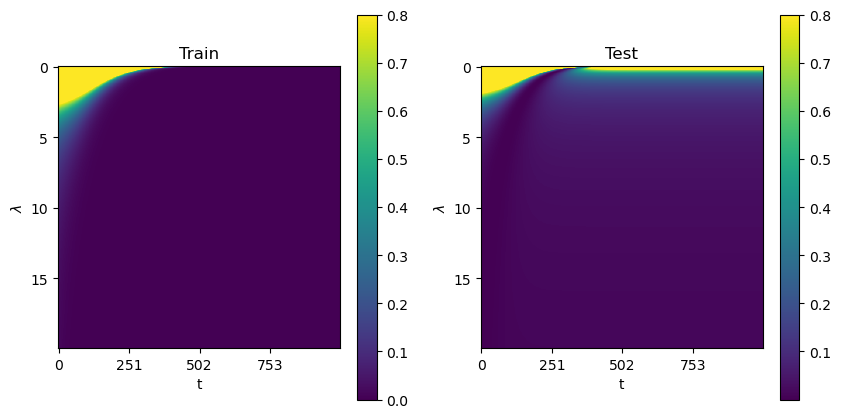

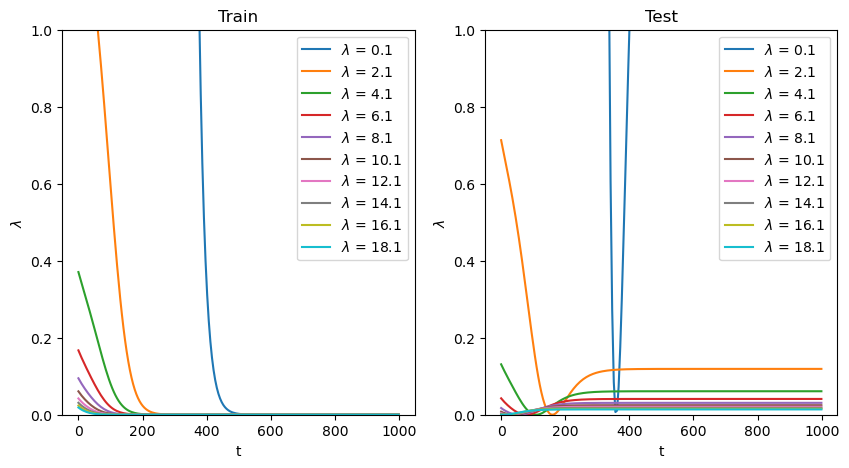

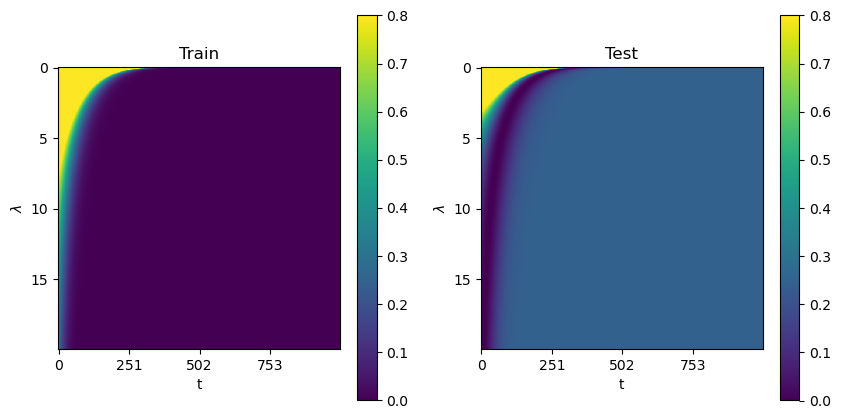

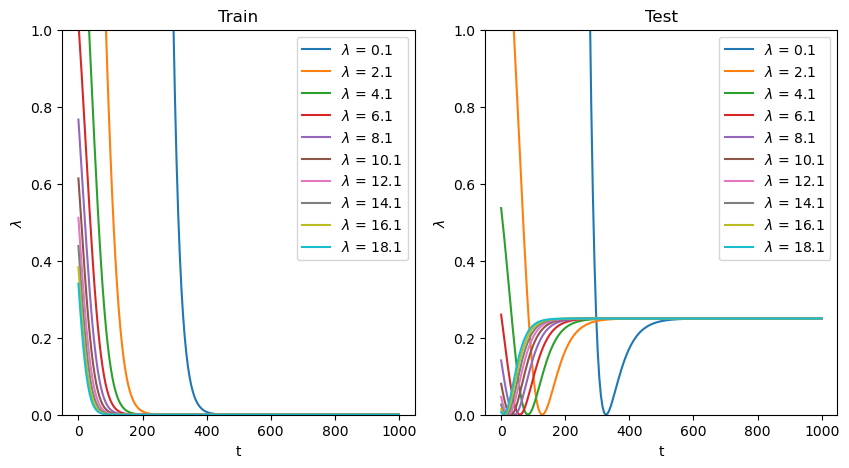

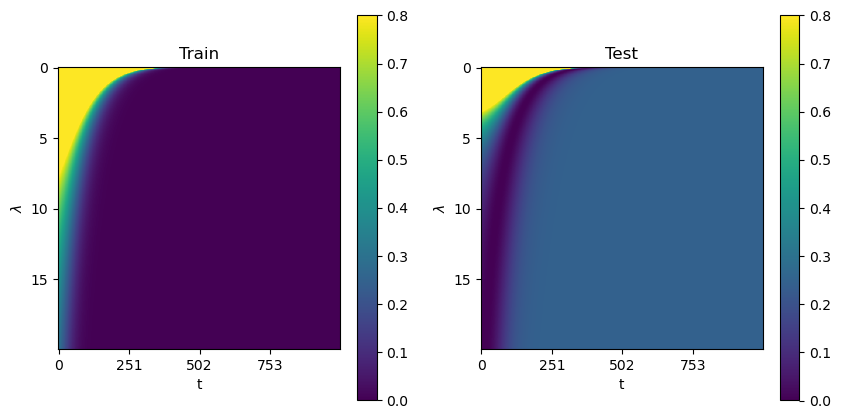

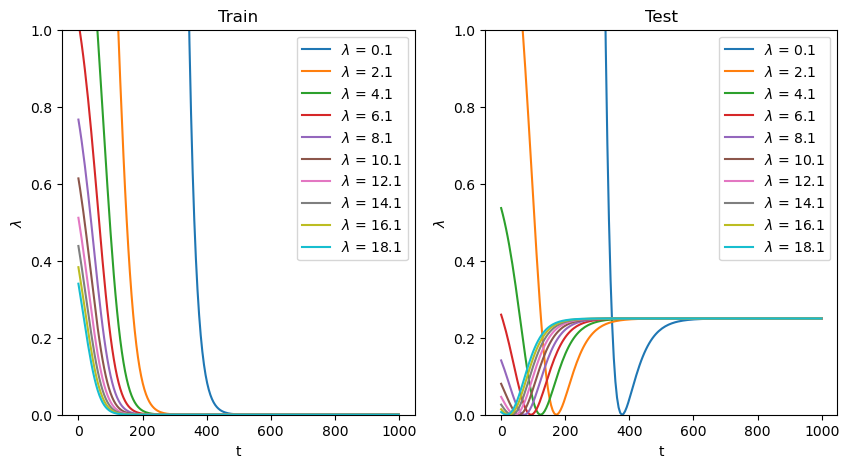

In [33]:
# Diff l, r, c > 0

tau = 999
res = 200
step = int((tau + 1) / res)
l_min, l_max = 0.1, 20

t_range = np.linspace(0, tau, res)
l_range = np.linspace(l_min, l_max, res)
ts, ls = np.meshgrid(t_range, l_range)

# "Exact"
tau_ex = 1000
step_ex = int(tau_ex / res)
t_range_ex = np.linspace(0, tau_ex, res)

u_dyn = loop_dynamics_l(c, r, s, l_range, u0, tau_ex)
mse_t_eq_r = mse_global(s, l_range.reshape(-1, 1), u_dyn[:, 0::step_ex])
mse_g_eq_r = mse_true(s, l_range.reshape(-1, 1), e, u_dyn[:, 0::step_ex])

plot_res(mse_t_eq_r, mse_g_eq_r, t_range, l_range, vmax=0.8)
plot_curves(mse_t_eq_r, mse_g_eq_r, t_range, it_range=l_range, it=r"$\lambda$")


# Approx.
mset_1, mset_2 = mse_train(c, r, s, s, l1, ls, d, p1, u0, ts) 
mseg_1, mseg_2 = mse_test(c, r, s, s, l1, ls, e, e, d, p1, u0, ts) 

plot_res(mset_1 + mset_2, mseg_1 + mseg_2, t_range, l_range, vmax=0.8)
plot_curves(mset_1 + mset_2, mseg_1 + mseg_2, t_range, it_range=l_range, it=r"$\lambda$")

# Approx. new (Ser bättre ut på test, men inte på träning? Eller beror lite på vad man kollar på)
mset_1, mset_2 = mse_train(0.4 * c, 0.96 * r, s, s, l1, ls, d, p1, u0, ts) 
mseg_1, mseg_2 = mse_test(0.4 * c, 0.96 * r, s, s, l1, ls, e, e, d, p1, u0, ts) 

plot_res(mset_1 + mset_2, mseg_1 + mseg_2, t_range, l_range, vmax=0.8)
plot_curves(mset_1 + mset_2, mseg_1 + mseg_2, t_range, it_range=l_range, it=r"$\lambda$")


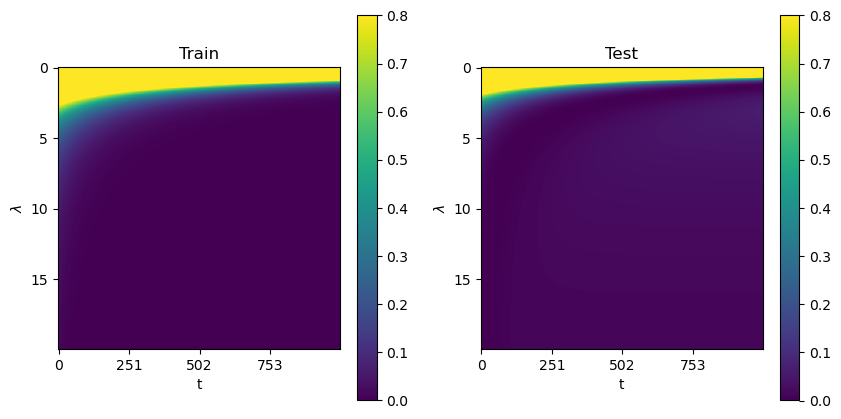

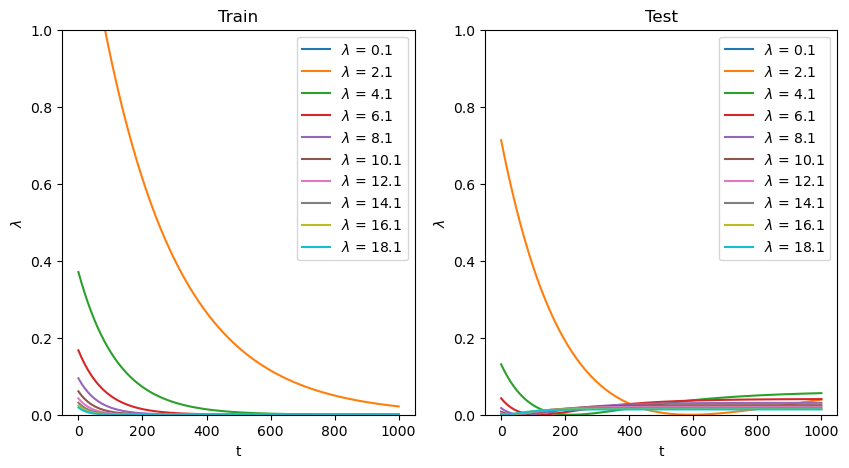

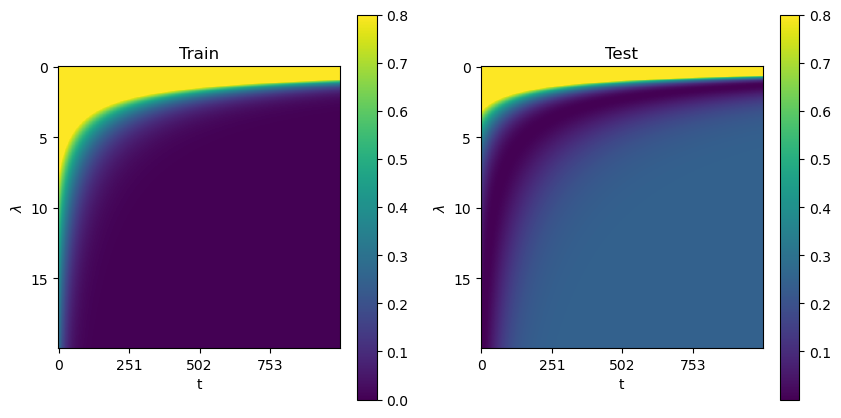

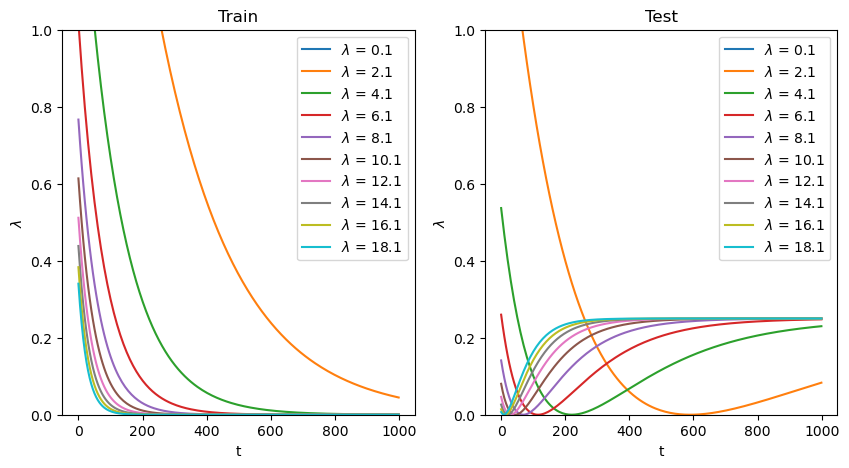

In [10]:
# Diff l, r = 0 

# "Exact"
u_dyn = loop_dynamics_l(c, 0, s, l_range, u0, tau_ex)
mse_t_eq_r = mse_global(s, l_range.reshape(-1, 1), u_dyn[:, 0::step_ex])
mse_g_eq_r = mse_true(s, l_range.reshape(-1, 1), e, u_dyn[:, 0::step_ex])

plot_res(mse_t_eq_r, mse_g_eq_r, t_range_ex, l_range, vmax=0.8)
plot_curves(mse_t_eq_r, mse_g_eq_r, t_range_ex, it_range=l_range, it=r"$\lambda$")

# Approx.
mset_1, mset_2 = mse_train(c, 0, s, s, l1, ls, d, p1, u0, ts) 
mseg_1, mseg_2 = mse_test(c, 0, s, s, l1, ls, e, e, d, p1, u0, ts) 

plot_res(mset_1 + mset_2, mseg_1 + mseg_2, t_range, l_range, vmax=0.8)
plot_curves(mset_1 + mset_2, mseg_1 + mseg_2, t_range, it_range=l_range, it=r"$\lambda$")


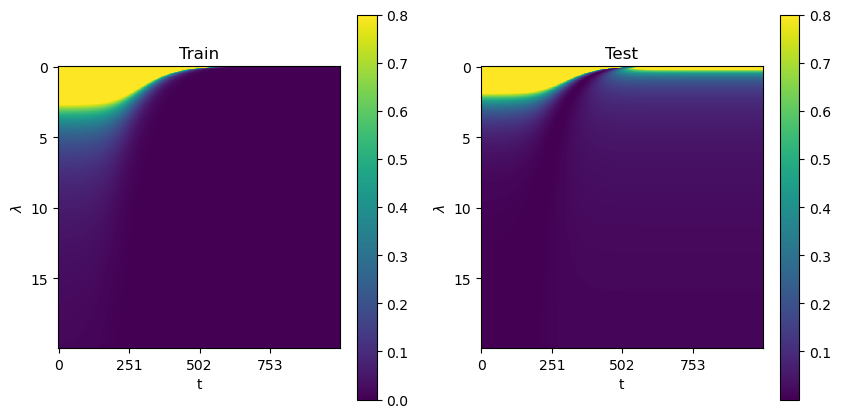

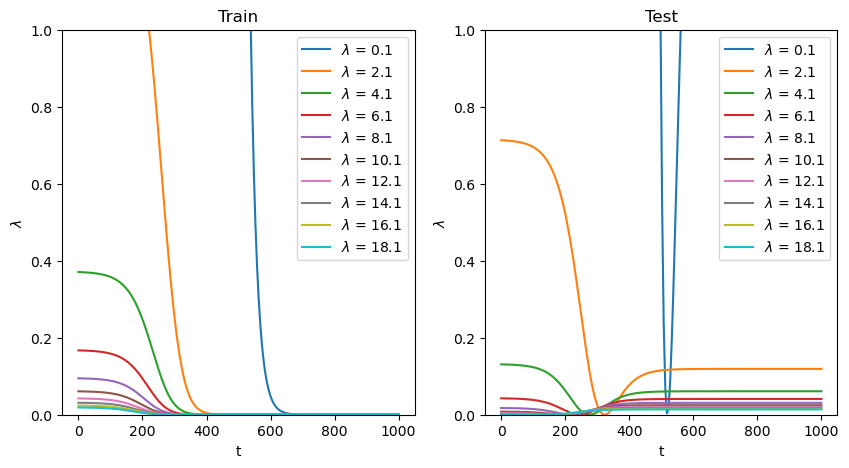

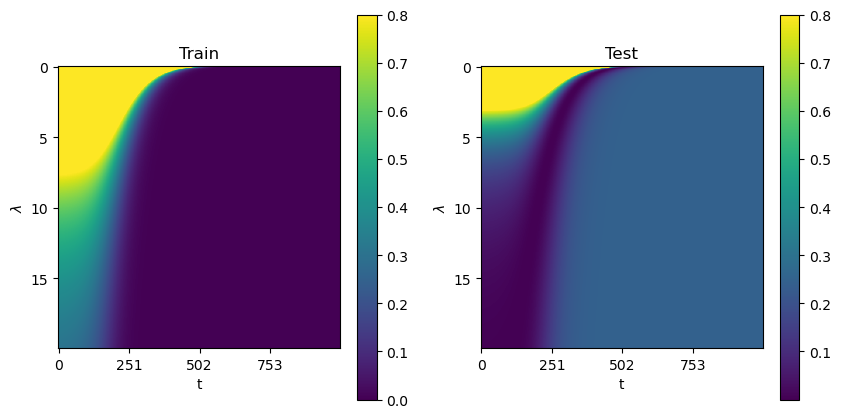

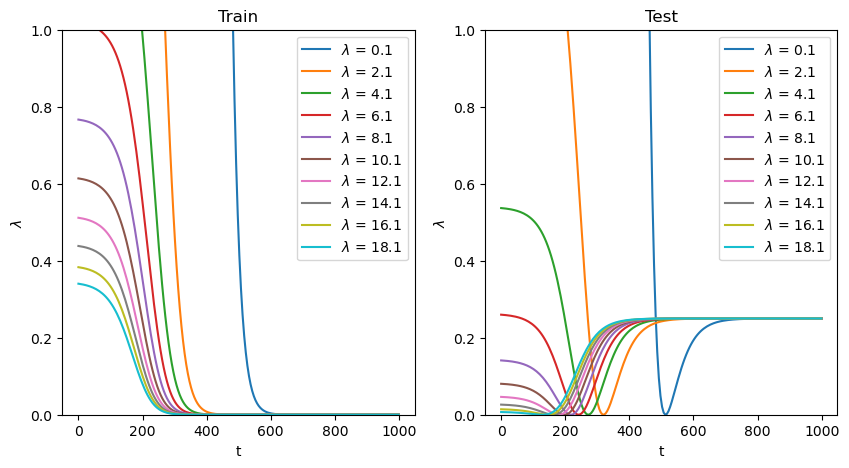

In [11]:
# Diff l, c = 0

# "Exact"
u_dyn = loop_dynamics_l(0, r, s, l_range, u0, tau_ex)
mse_t_eq_r = mse_global(s, l_range.reshape(-1, 1), u_dyn[:, 0::step_ex])
mse_g_eq_r = mse_true(s, l_range.reshape(-1, 1), e, u_dyn[:, 0::step_ex])

plot_res(mse_t_eq_r, mse_g_eq_r, t_range_ex, l_range, vmax=0.8)
plot_curves(mse_t_eq_r, mse_g_eq_r, t_range_ex, it_range=l_range, it=r"$\lambda$")

# Approx.
mset_1, mset_2 = mse_train(0, r, s, s, l1, ls, d, p1, u0, ts) 
mseg_1, mseg_2 = mse_test(0, r, s, s, l1, ls, e, e, d, p1, u0, ts) 

plot_res(mset_1 + mset_2, mseg_1 + mseg_2, t_range, l_range, vmax=0.8)
plot_curves(mset_1 + mset_2, mseg_1 + mseg_2, t_range, it_range=l_range, it=r"$\lambda$")


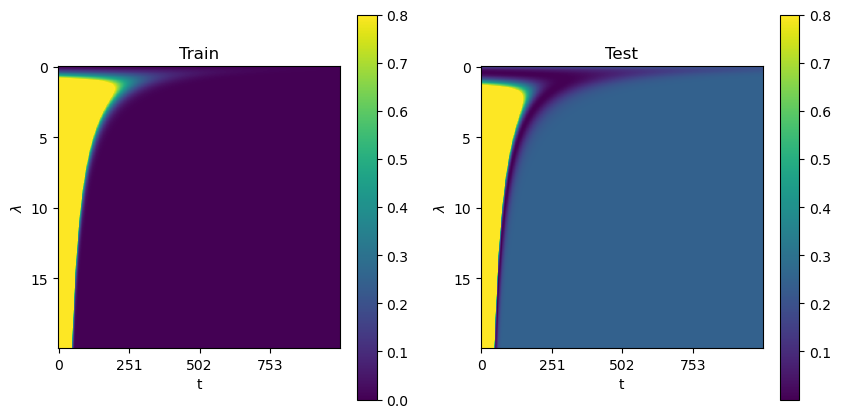

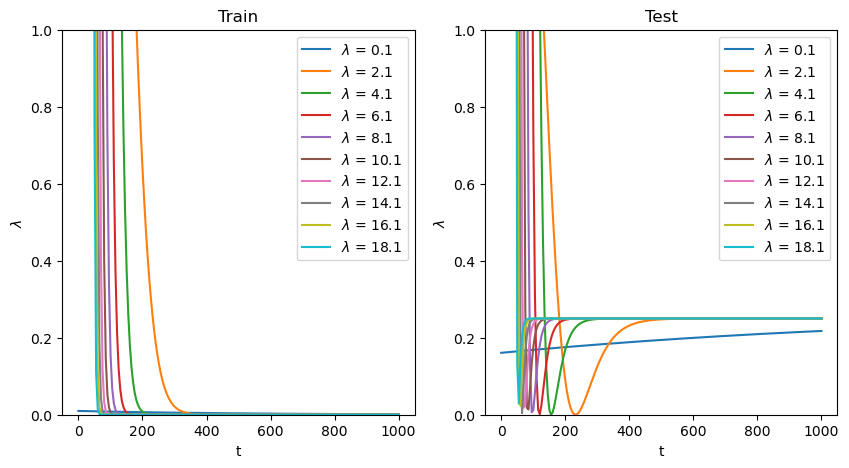

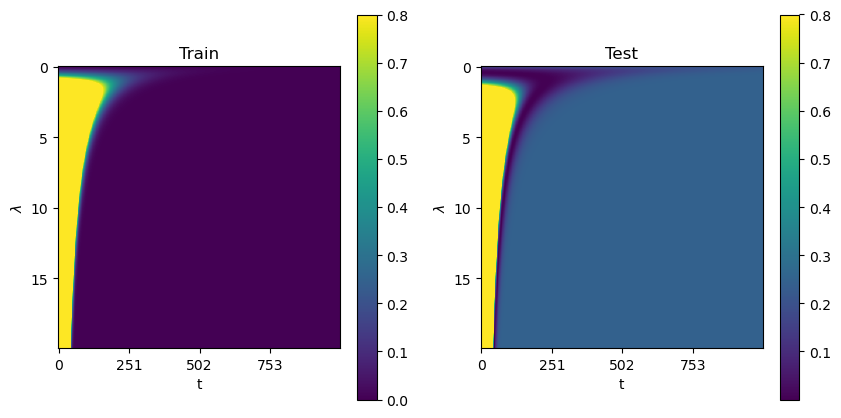

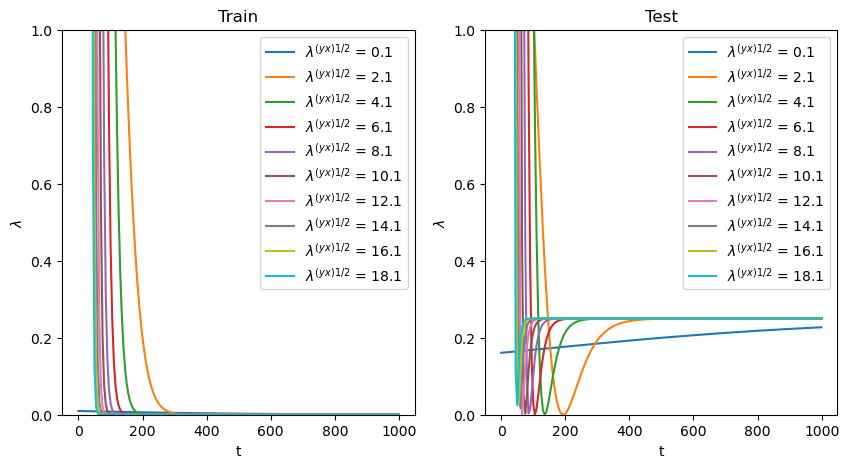

In [12]:
# Diff s, r, c > 0

s_min, s_max = 0.1, 20
s_range = np.linspace(s_min, s_max, res)

ts, ss = np.meshgrid(t_range, l_range)

# "Exact"
u_dyn = loop_dynamics_s(c, r, s_range, l1, u0, tau_ex)
mse_t_eq_r = mse_global(s_range.reshape(-1, 1), l1, u_dyn[:, 0::step_ex])
mse_g_eq_r = mse_true(s_range.reshape(-1, 1), l1, e, u_dyn[:, 0::step_ex])

plot_res(mse_t_eq_r, mse_g_eq_r, t_range_ex, l_range, vmax=0.8)
plot_curves(mse_t_eq_r, mse_g_eq_r, t_range_ex, it_range=l_range, it=r"$\lambda$")

# Approx.
mset_1, mset_2 = mse_train(c, r, s, ss, l1, l1, d, p1, u0, ts) 
mseg_1, mseg_2 = mse_test(c, r, s, ss, l1, l1, e, e, d, p1, u0, ts) 

plot_res(mset_1 + mset_2, mseg_1 + mseg_2, t_range, s_range, vmax=0.8) 
plot_curves(mset_1 + mset_2, mseg_1 + mseg_2, t_range, it_range=s_range, it=r"${\lambda^{(yx)}}^{1/2}$")


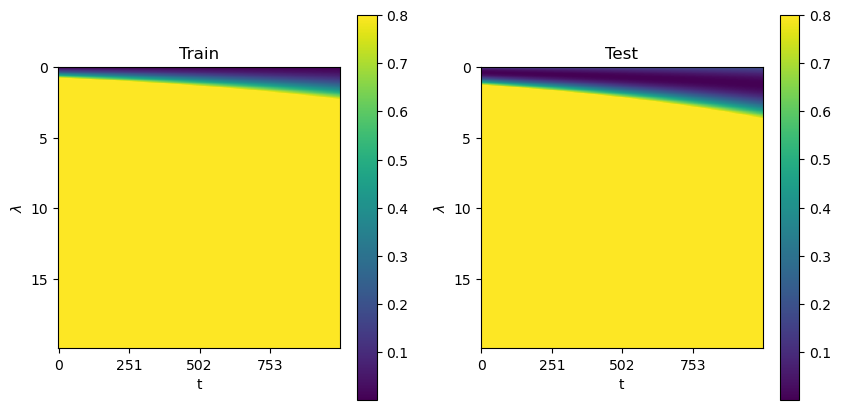

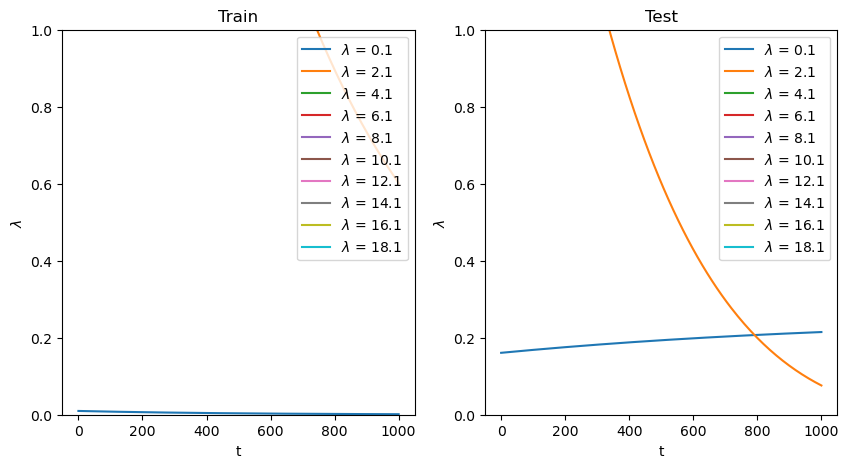

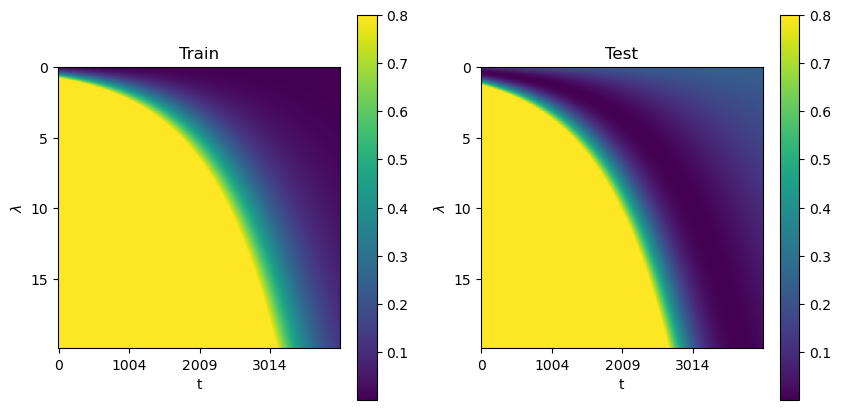

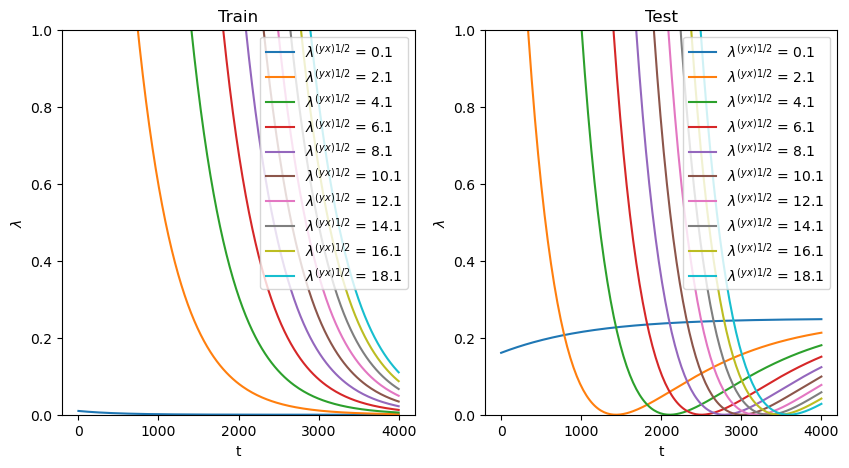

In [13]:
# Diff s, r = 0

tau2 = 3999
t_range_2 = np.linspace(0, tau2, res)
s_range = np.linspace(s_min, s_max, res)

ts2, ss2 = np.meshgrid(t_range_2, l_range)

# "Exact"
u_dyn = loop_dynamics_s(c, 0, s_range, l1, u0, tau_ex)
mse_t_eq_r = mse_global(s_range.reshape(-1, 1), l1, u_dyn[:, 0::step_ex])
mse_g_eq_r = mse_true(s_range.reshape(-1, 1), l1, e, u_dyn[:, 0::step_ex])

plot_res(mse_t_eq_r, mse_g_eq_r, t_range_ex, l_range, vmax=0.8)
plot_curves(mse_t_eq_r, mse_g_eq_r, t_range_ex, it_range=l_range, it=r"$\lambda$")

# Approx.
mset_1, mset_2 = mse_train(c, 0, s, ss2, l1, l1, d, p1, u0, ts2) 
mseg_1, mseg_2 = mse_test(c, 0, s, ss2, l1, l1, e, e, d, p1, u0, ts2) 

plot_res(mset_1 + mset_2, mseg_1 + mseg_2, t_range_2, s_range, vmax=0.8)
plot_curves(mset_1 + mset_2, mseg_1 + mseg_2, t_range_2, it_range=s_range, it=r"${\lambda^{(yx)}}^{1/2}$", ylim=1)

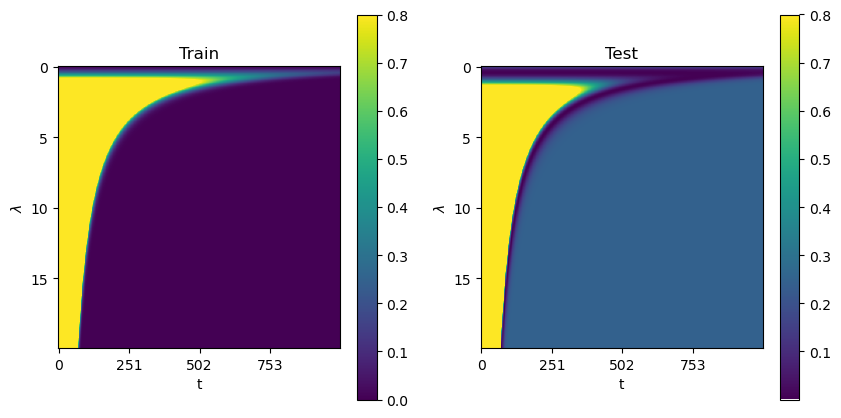

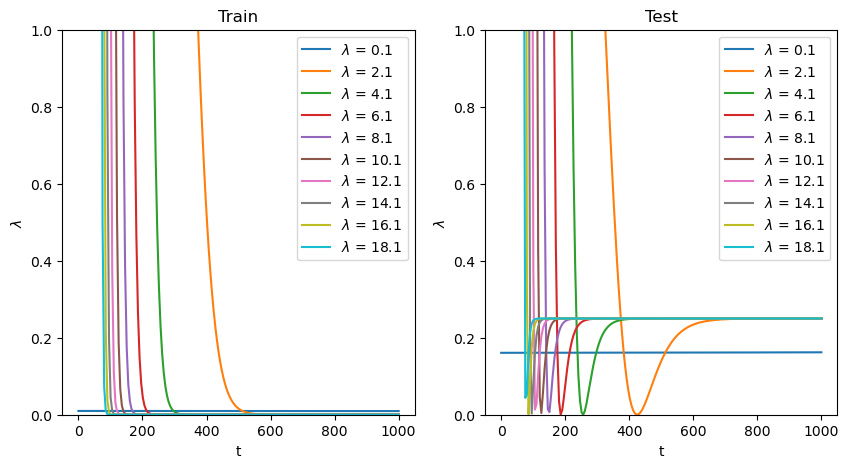

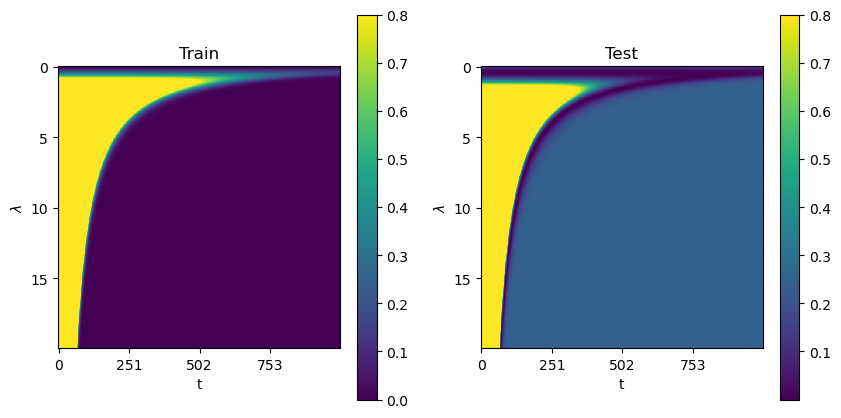

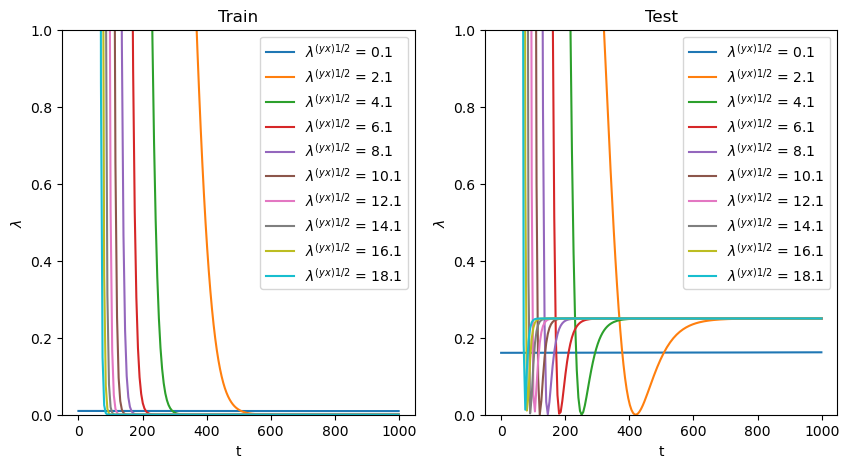

In [14]:
# Diff s, c = 0

# "Exact"
u_dyn = loop_dynamics_s(0, r, s_range, l1, u0, tau_ex)
mse_t_eq_r = mse_global(s_range.reshape(-1, 1), l1, u_dyn[:, 0::step_ex])
mse_g_eq_r = mse_true(s_range.reshape(-1, 1), l1, e, u_dyn[:, 0::step_ex])

plot_res(mse_t_eq_r, mse_g_eq_r, t_range_ex, l_range, vmax=0.8)
plot_curves(mse_t_eq_r, mse_g_eq_r, t_range_ex, it_range=l_range, it=r"$\lambda$")

# Approx.
mset_1, mset_2 = mse_train(0, r, s, ss, l1, l1, d, p1, u0, ts) 
mseg_1, mseg_2 = mse_test(0, r, s, ss, l1, l1, e, e, d, p1, u0, ts) 

plot_res(mset_1 + mset_2, mseg_1 + mseg_2, t_range, s_range, vmax=0.8)
plot_curves(mset_1 + mset_2, mseg_1 + mseg_2, t_range, it_range=s_range, it=r"${\lambda^{(yx)}}^{1/2}$")

## Two singular values

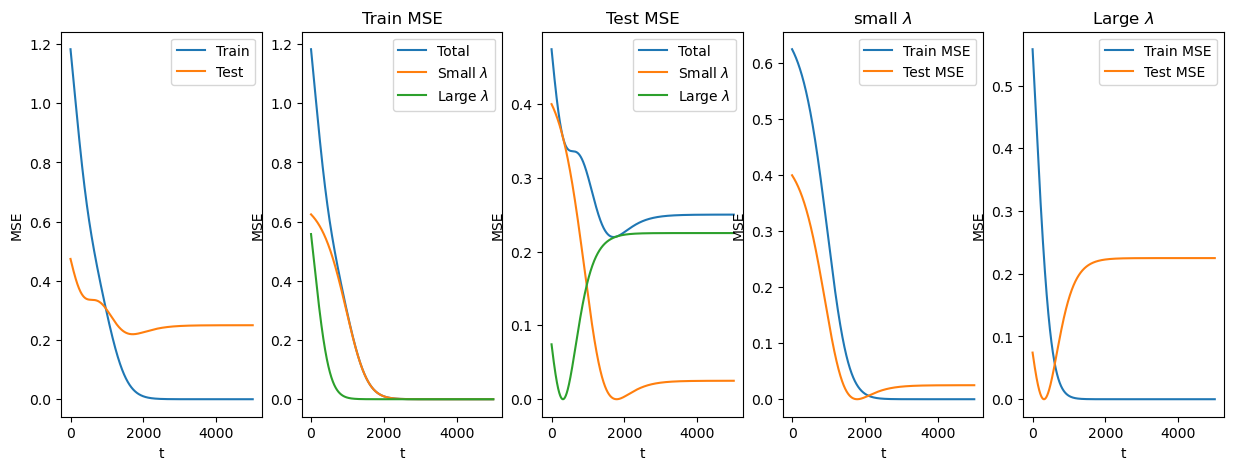

In [46]:
# Test
tau = 5000
ts = np.linspace(0, tau, tau)


c, r = 0.0001, 0.001
s = 2.5
l1, l2 = 1, 10

d = 10
p2 = 9
u0 = 0.001
e = 0.5

mset_1, mset_2 = mse_train(c, r, s, s, l1, l2, d, p2, u0, ts)
mseg_1, mseg_2 = mse_test(c, r, s, s, l1, l2, e, e, d, p2, u0, ts) 


fig, ax = plt.subplots(1, 5, figsize=(15, 5))

ax[0].plot(ts, mset_1 + mset_2, label = "Train")
ax[0].plot(ts, mseg_1 + mseg_2, label = "Test")

ax[1].plot(ts, mset_1 + mset_2, label = "Total")
ax[1].plot(ts, mset_1, label = fr"Small $\lambda$")
ax[1].plot(ts, mset_2, label = fr"Large $\lambda$")
ax[1].set_title("Train MSE")

ax[2].plot(ts, mseg_1 + mseg_2, label = "Total")
ax[2].plot(ts, mseg_1, label = fr"Small $\lambda$")
ax[2].plot(ts, mseg_2, label = fr"Large $\lambda$")
ax[2].set_title("Test MSE")

ax[3].plot(ts, mset_1, label = "Train MSE")
ax[3].plot(ts, mseg_1, label = "Test MSE")
ax[3].set_title(fr"small $\lambda$")

ax[4].plot(ts, mset_2, label = "Train MSE")
ax[4].plot(ts, mseg_2, label = "Test MSE")
ax[4].set_title(fr"Large $\lambda$")

for i in range(5):
    ax[i].set_xlabel("t")
    ax[i].set_ylabel("MSE")
    ax[i].legend()

plt.show()

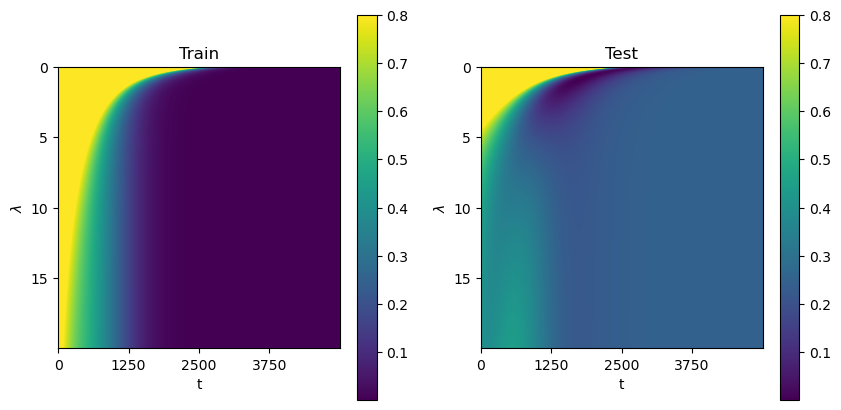

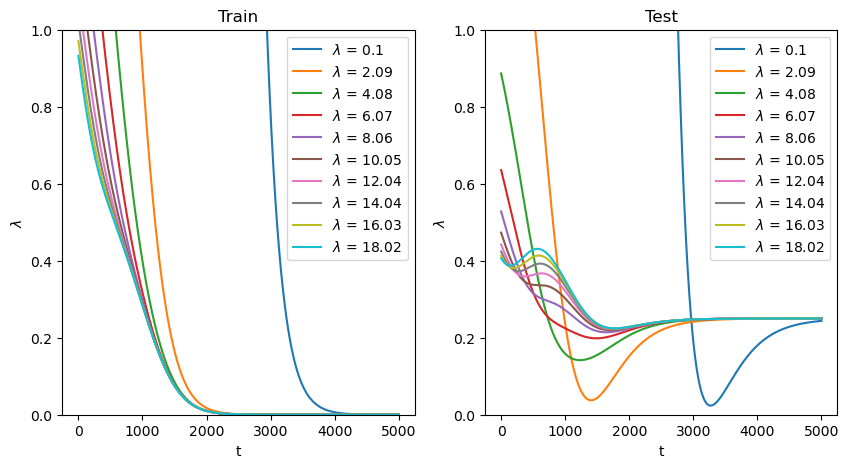

In [16]:
# Diff l, r, c > 0

tau = 4999
res = 2500
l_min, l_max = 0.1, 20

t_range = np.linspace(0, tau, res)
l_range = np.linspace(l_min, l_max, res)

ts, ls = np.meshgrid(t_range, l_range)

mset_1, mset_2 = mse_train(c, r, s, s, l1, ls, d, p2, u0, ts) 
mseg_1, mseg_2 = mse_test(c, r, s, s, l1, ls, e, e, d, p2, u0, ts) 

plot_res(mset_1 + mset_2, mseg_1 + mseg_2, t_range, l_range, vmax=0.8)
plot_curves(mset_1 + mset_2, mseg_1 + mseg_2, t_range, it_range=l_range, it=r"$\lambda$")


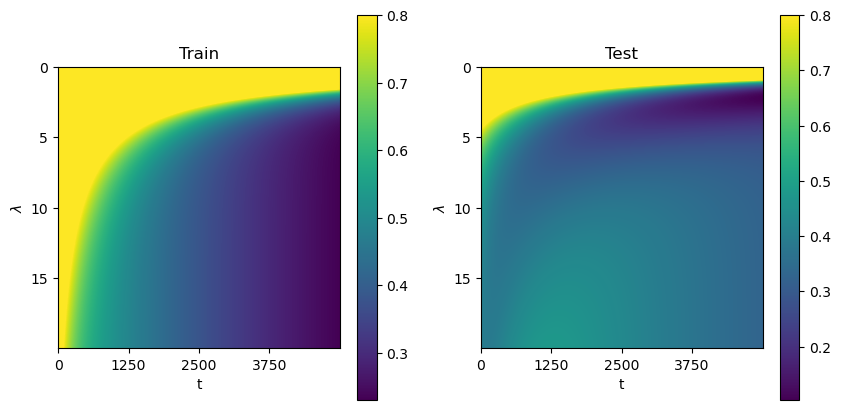

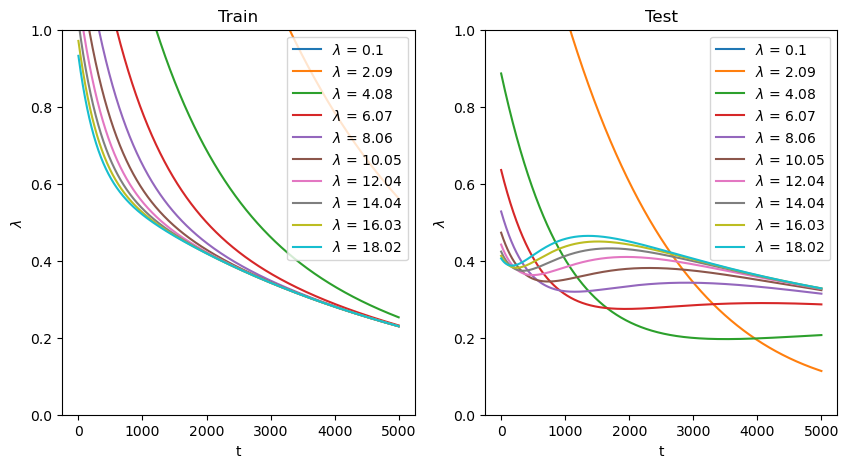

In [17]:
# Diff l, r = 0

mset_1, mset_2 = mse_train(c, 0, s, s, l1, ls, d, p2, u0, ts) 
mseg_1, mseg_2 = mse_test(c, 0, s, s, l1, ls, e, e, d, p2, u0, ts) 

plot_res(mset_1 + mset_2, mseg_1 + mseg_2, t_range, l_range, vmax=0.8)
plot_curves(mset_1 + mset_2, mseg_1 + mseg_2, t_range, it_range=l_range, it=r"$\lambda$")


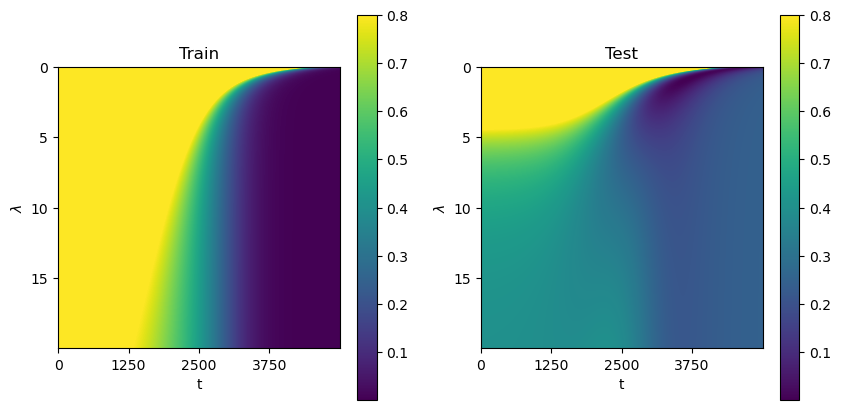

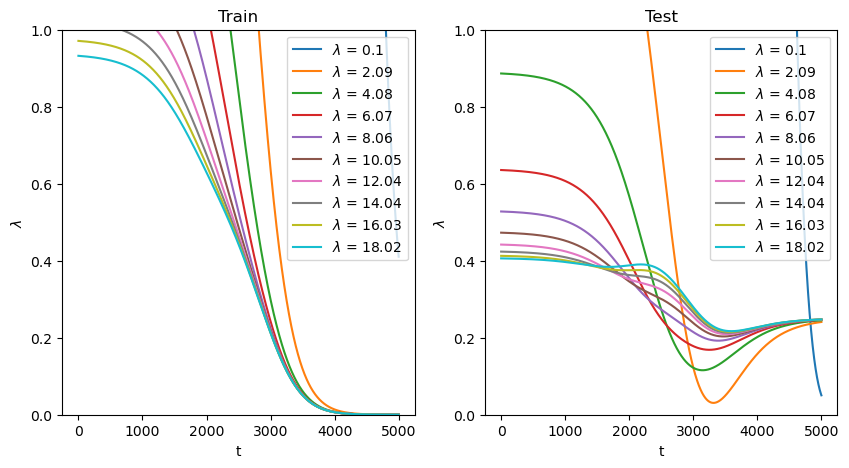

In [270]:
# Diff l, c = 0

mset_1, mset_2 = mse_train(0, r, s, s, l1, ls, d, p2, u0, ts) 
mseg_1, mseg_2 = mse_test(0, r, s, s, l1, ls, e, e, d, p2, u0, ts) 

plot_res(mset_1 + mset_2, mseg_1 + mseg_2, t_range, l_range, vmax=0.8)
plot_curves(mset_1 + mset_2, mseg_1 + mseg_2, t_range, it_range=l_range, it=r"$\lambda$")


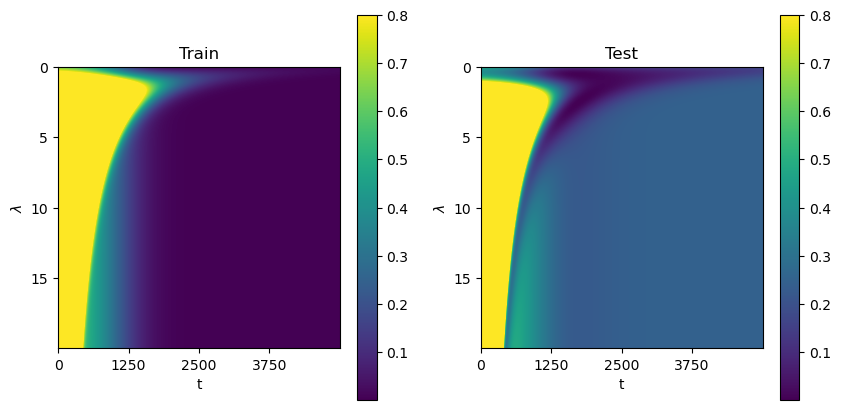

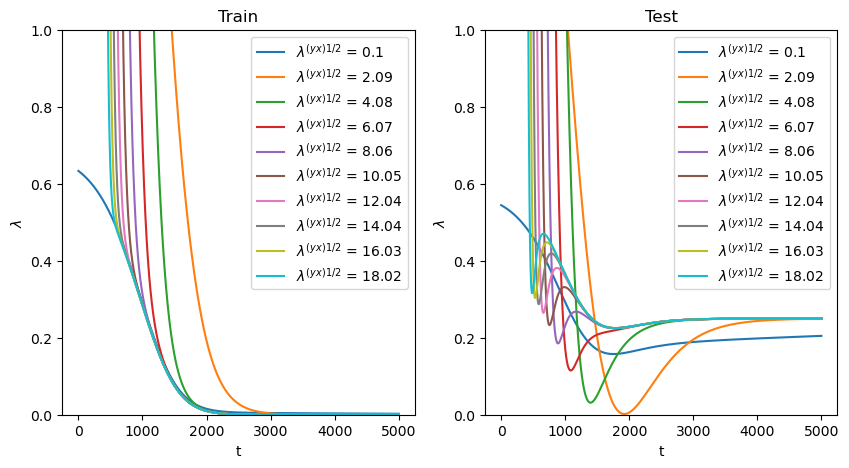

In [271]:
# Diff s, r, c > 0

# VI MÅSTE KANSKE SKALA OM LOSSEN HÄR PÅ NÅGOT SÄTT?

tau = 4999
res = 2500
s_min, s_max = 0.1, 20

t_range = np.linspace(0, tau, res)
s_range = np.linspace(s_min, s_max, res)

ts, ss = np.meshgrid(t_range, l_range)

mset_1, mset_2 = mse_train(c, r, s, ss, l1, l1, d, p2, u0, ts) 
mseg_1, mseg_2 = mse_test(c, r, s, ss, l1, l1, e, e, d, p2, u0, ts) 

plot_res(mset_1 + mset_2, mseg_1 + mseg_2, t_range, s_range, vmax=0.8) 
plot_curves(mset_1 + mset_2, mseg_1 + mseg_2, t_range, it_range=s_range, it=r"${\lambda^{(yx)}}^{1/2}$")


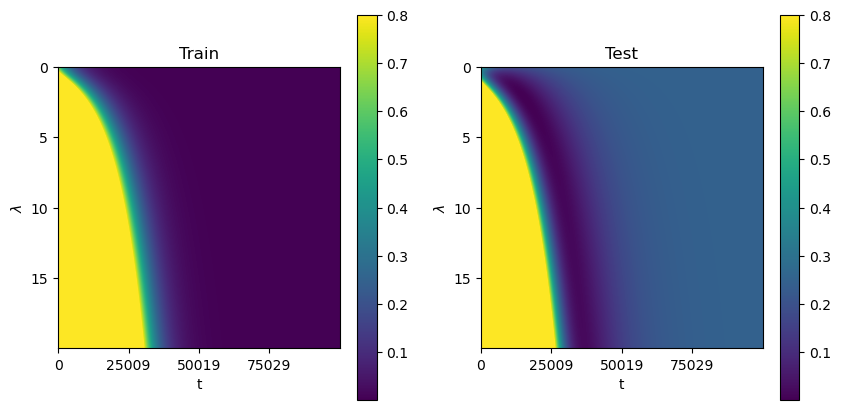

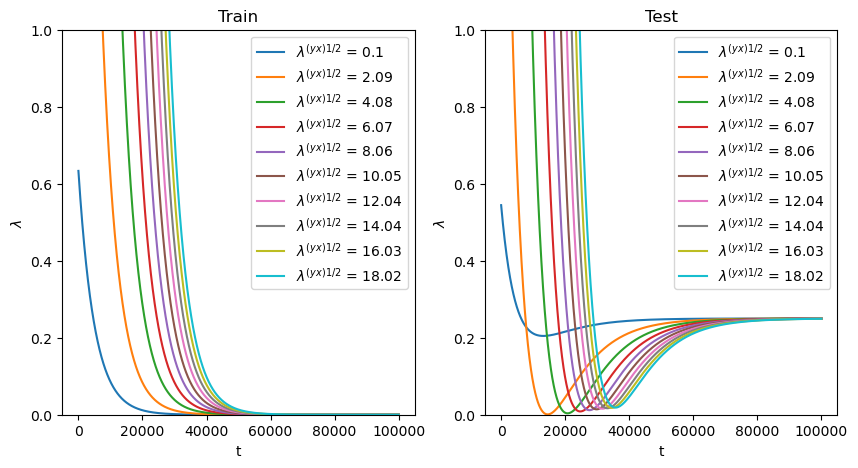

In [272]:
# Diff s, r = 0

tau2 = 99999
t_range_2 = np.linspace(0, tau2, res)
s_range = np.linspace(s_min, s_max, res)

ts2, ss2 = np.meshgrid(t_range_2, l_range)

mset_1, mset_2 = mse_train(c, 0, s, ss2, l1, l1, d, p2, u0, ts2) 
mseg_1, mseg_2 = mse_test(c, 0, s, ss2, l1, l1, e, e, d, p2, u0, ts2) 

plot_res(mset_1 + mset_2, mseg_1 + mseg_2, t_range_2, s_range, vmax=0.8)
plot_curves(mset_1 + mset_2, mseg_1 + mseg_2, t_range_2, it_range=s_range, it=r"${\lambda^{(yx)}}^{1/2}$", ylim=1)

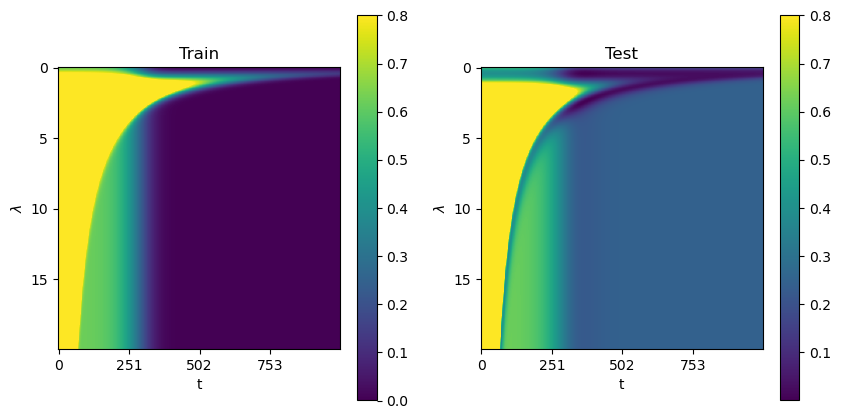

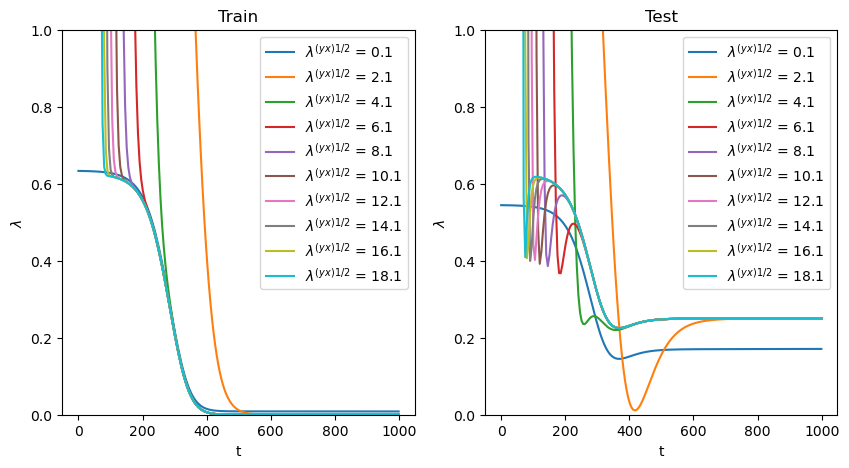

In [34]:
# Diff s, c = 0

mset_1, mset_2 = mse_train(0, r, s, ss, l1, l1, d, p2, u0, ts) 
mseg_1, mseg_2 = mse_test(0, r, s, ss, l1, l1, e, e, d, p2, u0, ts) 

plot_res(mset_1 + mset_2, mseg_1 + mseg_2, t_range, s_range, vmax=0.8)
plot_curves(mset_1 + mset_2, mseg_1 + mseg_2, t_range, it_range=s_range, it=r"${\lambda^{(yx)}}^{1/2}$")